# IMEX-RB: A Fast and Stable Time Integration Method


In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

In [2]:
import numpy as np
import scipy
from src.imexrb import imexrb
from src.euler import backward_euler, forward_euler
import utils.mpl_pubstyle
from utils.errors import compute_errors
from utils.helpers import *
# Suppress matplotlib logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

16:50:51 - matplotlib - DEBUG - matplotlib data path: /home/francesco/anaconda3/envs/imexrb-FD/lib/python3.13/site-packages/matplotlib/mpl-data
16:50:51 - matplotlib - DEBUG - CONFIGDIR=/home/francesco/.config/matplotlib
16:50:51 - matplotlib - DEBUG - interactive is False
16:50:51 - matplotlib - DEBUG - platform is linux


## Solving a 3D Advection Diffusion Equation

The advection–diffusion problem is defined over the spatial domain $\Omega = [0,1] \times [0,1] \times [0,1]$ and the time interval $[0,1]$:

$$
\begin{cases}
\dfrac{\partial u}{\partial t} + c_x \dfrac{\partial u}{\partial x} + c_y \dfrac{\partial u}{\partial y} = \mu \Delta u,
  & \mathbf{x} \in \Omega,\; t > 0, \\[1em]
u(\mathbf{x}, 0) = u_0(\mathbf{x}), 
  & \mathbf{x} \in \Omega, \\[0.5em]
u(\mathbf{x}, t) = g(\mathbf{x}), 
  & \mathbf{x} \in \partial \Omega,
\end{cases}
$$

where $\mathbf{x} = [x, y]^{T}$. We choose
$$
c_x = c_y = 0.8, 
\quad
\mu = 0.1.
$$

The analytical (exact) solution, taken from [@SALMAN2022106780, p. 3], is

$$
u_{\mathrm{ex}}(\mathbf{x}, t)
= \frac{1}{4t + 1}
  \exp\!\Biggl(
    -\frac{(x - c_x t - 0.5)^2}{\mu\,(4t + 1)}
    \;-\;
    \frac{(y - c_y t - 0.5)^2}{\mu\,(4t + 1)}
  \Biggr).
$$

---

We can now integrate in time, to show the performance of IMEX-RB compared to classic 1st order integration schemes, i.e. Backward/Forward Euler.

In [13]:
from src.problemsPDE import AdvDiff3D

problem_name = "AdvDiff3D"
Lx = 1
Ly = 2
Lz = 3
mu = 0.01
vx = 1
vy = 0.5 #vx
vz = 0.5 # vx
t0 = 0.0
tf = 1.0
tspan = [t0, tf]
# Discretization
Nx = 2
Ny = 3
Nz = 4

# Define the problem object
problem = AdvDiff3D(Nx, Ny, Nz, Lx, Ly, Lz, mu, vx, vy, vz)
u0 = problem.initial_condition()


In [4]:
# Define path for saving plots and other variables
results_path = f"results/{problem_name}"
os.makedirs(results_path, exist_ok=True)

We now integrate over time, using different schemes. First of all, we define some parameters for the time integration

In [5]:
# Define number of timesteps
Nt = 200
# Define epsilon for absolute stability condition
epsilon = 1e-3 # 1.0/np.linalg.cond(problem.A)
# Define max dimension of subspace before subiterations
maxsize = 10 #int(np.ceil(np.pow(problem.Nh, 1/3)))
# Define max allowed enlargement during subiterations
maxsubiter = maxsize

Let us have a look at the selected dimension for the subspace $\mathcal{V}_n$

In [6]:
print(f"The subspace has an initial dim = {maxsize}, and such dim can grow up to {maxsize + maxsubiter}"
      f"\nThe full order problem has dim = {problem.Nh}")
print(f"The selected \\varepsilon is {epsilon}")
print(f"Local x-Peclet number is approx {vx * tf / (2 * mu * Nt)}")

The subspace has an initial dim = 10, and such dim can grow up to 20
The full order problem has dim = 132651
The selected \varepsilon is 0.001
Local x-Peclet number is approx 0.25


We compute the number of timesteps making forward Euler stable, for comparison with the other schemes

In [7]:
# Nt_FE = compute_steps_stability_FE(problem, tspan)
Nt_FE = Nt

In [8]:
# First, IMEX-RB
uIMEX, tvec, subiter = imexrb(problem, u0, tspan, Nt, epsilon, maxsize, maxsubiter)
uBE, *_ = backward_euler(problem, u0, tspan, Nt, solver="gmres")
# Forward Euler may throw errors if unstable
uFE, tvecFE, *_ = forward_euler(problem, u0, tspan, Nt_FE)

16:51:01 - src.imexrb - DEBUG - IMEX-RB: stability condition NOT met (times/total):0/200


### Compute and plot errors
We plot the errors over time for the previously chosen parameters. Note that the stability requirement for FE make it significantly more precise than BE and IMEX-RB, which attain stability for a much larger $\Delta t$

16:51:21 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
16:51:21 - PIL.PngImagePlugin - DEBUG - STREAM b'PLTE' 41 48
16:51:21 - PIL.PngImagePlugin - DEBUG - STREAM b'tRNS' 101 15
16:51:21 - PIL.PngImagePlugin - DEBUG - STREAM b'pHYs' 128 9
16:51:21 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 149 157
16:51:21 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
16:51:21 - PIL.PngImagePlugin - DEBUG - STREAM b'PLTE' 41 48
16:51:21 - PIL.PngImagePlugin - DEBUG - STREAM b'tRNS' 101 15
16:51:21 - PIL.PngImagePlugin - DEBUG - STREAM b'pHYs' 128 9
16:51:21 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 149 221
16:51:21 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
16:51:21 - PIL.PngImagePlugin - DEBUG - STREAM b'PLTE' 41 48
16:51:21 - PIL.PngImagePlugin - DEBUG - STREAM b'tRNS' 101 15
16:51:21 - PIL.PngImagePlugin - DEBUG - STREAM b'pHYs' 128 9
16:51:21 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 149 188
16:51:21 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
16:51:21 - PIL.

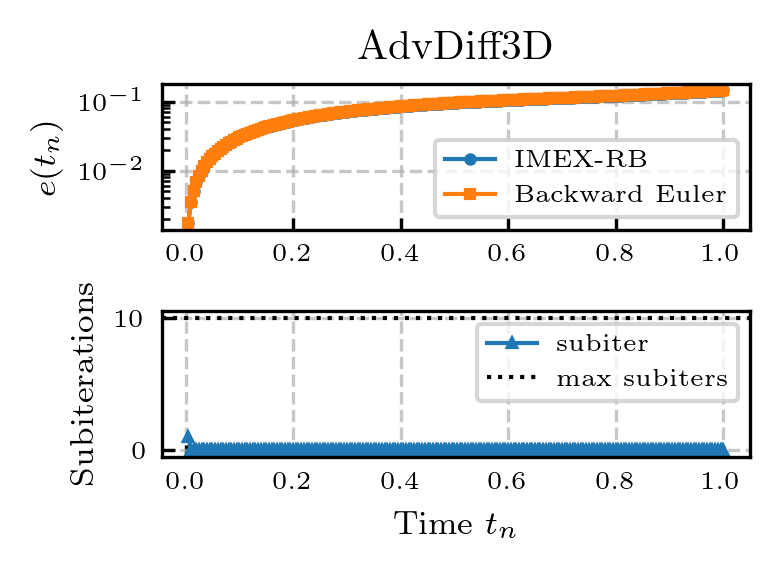

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.subplot(2,1,1)
# Compute relative errors over time 
errIMEX = compute_errors(uIMEX, tvec, problem)
errBE = compute_errors(uBE, tvec, problem)
errFE = compute_errors(uFE, tvecFE, problem)

# Plot the errors
plt.semilogy(tvec[1:], errIMEX, label="IMEX-RB", marker='o')
plt.semilogy(tvec[1:], errBE, label="Backward Euler", marker='s')
# plt.semilogy(tvecFE[1:], errFE, label="Forward Euler (stable)", marker='^')

plt.ylabel(r"$e(t_n)$")
plt.title(f"{problem_name}")
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(tvec[1:], subiter, label="subiter", marker="^")
plt.xlabel(r"Time $t_n$")
plt.ylabel(r"Subiterations")
plt.axhline(maxsubiter, linestyle=":", color="k", label=r"max subiters")
plt.legend()

# Show the plot
plt.show()

### Plot the animation of the solution
Note that an animated plot in jupyter is not straightforward, and that is why there are some weird commands

Go back to `matplotlib inline` (after animation)

In [10]:
plt.close('all')
from IPython.display import clear_output
clear_output(wait=True)
%matplotlib inline

## Convergence test
We run a convergence test by computing the error at final time for different choices of $N_t$

### CPU Time to solution

We now compare the times required by IMEX-RB and BE to obtain a stable solution
N.W.: While we will keep $N_t$ fixed for IMEX-RB and BE, we will compute the $N_t$ making FE stable at each different problem size